In [ ]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.notebook import tqdm

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


In [ ]:
from glob import glob

In [ ]:
train_path = glob('cityscapes_data/train/*')
valid_path = glob('cityscapes_data/val/*')

In [ ]:
train_dir = "cityscapes_data_new/train/"
val_dir = "cityscapes_data_new/val/"

In [ ]:
import os
train_fns = os.listdir(train_dir)
val_fns = os.listdir(val_dir)
print(len(train_fns), len(val_fns))

2352 356


## 2. Analyze data

cityscapes_data_new/train/1.jpg


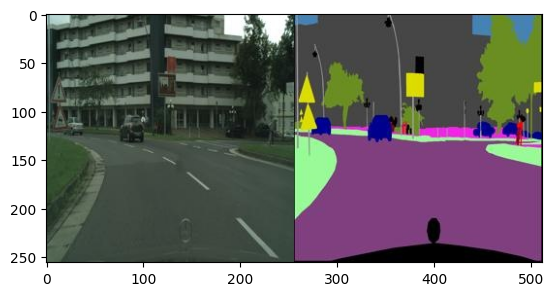

In [ ]:
sample_image_fp = os.path.join(train_dir, train_fns[0])
sample_image = Image.open(sample_image_fp).convert("RGB")
plt.imshow(sample_image)
print(sample_image_fp)

In [ ]:
def split_image(image):
    image = np.array(image)
    cityscape, label = image[:, :256, :], image[:, 256:, :]
    return cityscape, label

(256, 512, 3)
0 255 0 255


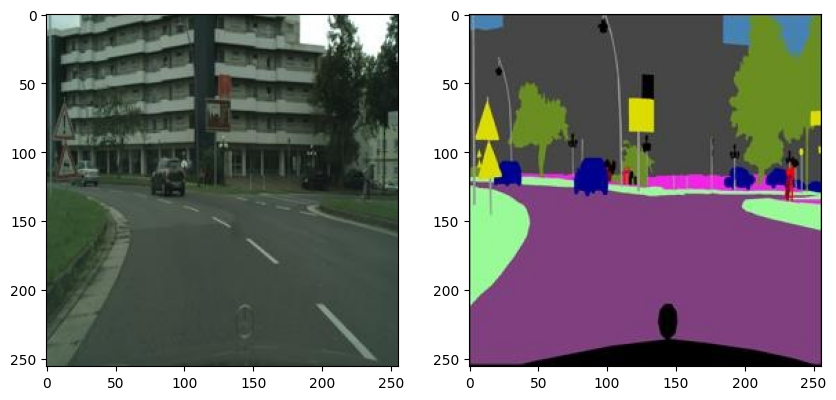

In [ ]:
sample_image = np.array(sample_image)
print(sample_image.shape)
cityscape, label = split_image(sample_image)
print(cityscape.min(), cityscape.max(), label.min(), label.max())
cityscape, label = Image.fromarray(cityscape), Image.fromarray(label)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(cityscape)
axes[1].imshow(label)

## 3. Define Labels

In [ ]:
num_items = 1000
color_array = np.random.choice(range(256), 3*num_items).reshape(-1, 3)
print(color_array.shape)
print(color_array[:5, :])

(1000, 3)
[[ 10  95 178]
 [ 54 149 112]
 [161 212  27]
 [232 150  81]
 [111  98  35]]


In [ ]:
num_classes = 5
label_model = KMeans(n_clusters=num_classes)
label_model.fit(color_array)

KMeans(n_clusters=5)

In [ ]:
label_model.predict(color_array[:30, :])

array([1, 1, 0, 0, 4, 2, 2, 1, 3, 3, 3, 0, 4, 3, 4, 4, 1, 0, 3, 4, 3, 1,
       3, 4, 2, 0, 0, 2, 4, 0])

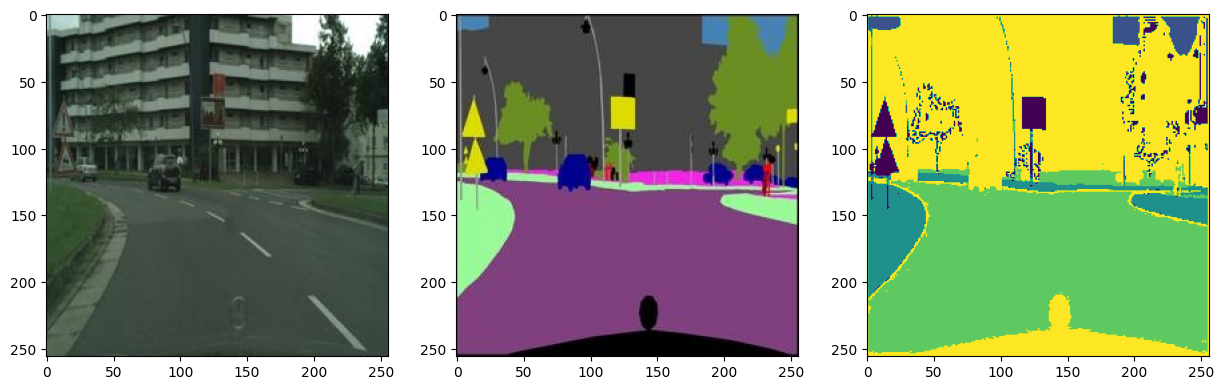

In [ ]:
cityscape, label = split_image(sample_image)
label_class = label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(cityscape)
axes[1].imshow(label)
axes[2].imshow(label_class)

In [ ]:
label_class

array([[6, 6, 6, ..., 6, 6, 6],
       [6, 0, 0, ..., 6, 6, 6],
       [6, 0, 4, ..., 5, 5, 6],
       ...,
       [6, 0, 0, ..., 0, 0, 6],
       [6, 6, 6, ..., 6, 6, 6],
       [6, 6, 6, ..., 6, 6, 6]])

In [ ]:
class CityscapeDataset(Dataset):
    def __init__(self, image_dir, label_model):
        self.image_dir = image_dir
        self.image_fns = os.listdir(image_dir)
        self.label_model = label_model
    def __len__(self):
        return len(self.image_fns)
    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.image_dir, image_fn)
        image = Image.open(image_fp).convert('RGB')
        image = np.array(image)
        cityscape, label = self.split_image(image)
        label_class = self.label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
        cityscape = self.transform(cityscape)
        label_class = torch.Tensor(label_class).long()
        return cityscape, label_class
    def split_image(self, image):
        image = np.array(image)
        cityscape, label = image[:, :256, :], image[:, 256:, :]
        return cityscape, label
    def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [ ]:
dataset = CityscapeDataset(train_dir, label_class)
print(len(dataset))

2352


In [ ]:
valdata = CityscapeDataset(valid_path, val_dir)

In [ ]:
data_loader = DataLoader(dataset, batch_size=4)
print(len(dataset), len(data_loader))
X, Y = next(iter(data_loader))
print(X.shape, Y.shape)

2352 588
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])


In [ ]:
batch_size = 4
val_loader = DataLoader(valdata,4)

In [ ]:
cityscape, label_class = dataset[0]
print(cityscape.shape, label_class.shape)

torch.Size([3, 256, 256]) torch.Size([256, 256])


In [ ]:
class Convblock(nn.Module):
      def __init__(self,input_channel,output_channel,kernal=3,stride=1,padding=1):   
        super().__init__()
        self.convblock = nn.Sequential(
            nn.Conv2d(input_channel,output_channel,kernal,stride,padding),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(output_channel,output_channel,kernal),
            nn.ReLU(inplace=True),
        )
      def forward(self,x):
        x = self.convblock(x)
        return x

In [ ]:
class UNet(nn.Module):
    def __init__(self,input_channel,retain=True):
        super().__init__()
        self.conv1 = Convblock(input_channel,32)
        self.conv2 = Convblock(32,64)
        self.conv3 = Convblock(64,128)
        self.conv4 = Convblock(128,256)
        self.neck = nn.Conv2d(256,512,3,1)
        self.upconv4 = nn.ConvTranspose2d(512,256,3,2,0,1)
        self.dconv4 = Convblock(512,256)
        self.upconv3 = nn.ConvTranspose2d(256,128,3,2,0,1)
        self.dconv3 = Convblock(256,128)
        self.upconv2 = nn.ConvTranspose2d(128,64,3,2,0,1)
        self.dconv2 = Convblock(128,64)
        self.upconv1 = nn.ConvTranspose2d(64,32,3,2,0,1)
        self.dconv1 = Convblock(64,32)
        self.out = nn.Conv2d(32,3,1,1)
        self.retain = retain
    def forward(self,x):
        conv1 = self.conv1(x)
        pool1 = F.max_pool2d(conv1,kernel_size=2,stride=2)
        conv2 = self.conv2(pool1)
        pool2 = F.max_pool2d(conv2,kernel_size=2,stride=2)
        conv3 = self.conv3(pool2)
        pool3 = F.max_pool2d(conv3,kernel_size=2,stride=2)
        conv4 = self.conv4(pool3)
        pool4 = F.max_pool2d(conv4,kernel_size=2,stride=2)
        neck = self.neck(pool4)
        upconv4 = self.upconv4(neck)
        croped = self.crop(conv4,upconv4)
        dconv4 = self.dconv4(torch.cat([upconv4,croped],1))
        upconv3 = self.upconv3(dconv4)
        croped = self.crop(conv3,upconv3)
        dconv3 = self.dconv3(torch.cat([upconv3,croped],1))
        upconv2 = self.upconv2(dconv3)
        croped = self.crop(conv2,upconv2)
        dconv2 = self.dconv2(torch.cat([upconv2,croped],1))
        upconv1 = self.upconv1(dconv2)
        croped = self.crop(conv1,upconv1)
        dconv1 = self.dconv1(torch.cat([upconv1,croped],1))
        out = self.out(dconv1) 
        if self.retain == True:
            out = F.interpolate(out,list(x.shape)[2:])
        return out
    def crop(self,input_tensor,target_tensor):
        _,_,H,W = target_tensor.shape
        return transforms.CenterCrop([H,W])(input_tensor)

In [ ]:
model = UNet(num_classes=num_classes)

In [ ]:
data_loader = DataLoader(dataset, batch_size=4)
print(len(dataset), len(data_loader))
X, Y = next(iter(data_loader))
print(X.shape, Y.shape)

2352 588
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])


In [ ]:
Y_pred = model(X)
print(Y_pred.shape)

torch.Size([4, 10, 256, 256])


In [ ]:
batch_size = 2
epochs = 15
lr = 0.01

In [ ]:
dataset = CityscapeDataset(train_dir, label_model)
data_loader = DataLoader(dataset, batch_size=batch_size)

In [ ]:
model = UNet(num_classes=num_classes).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [ ]:
step_losses = []
epoch_losses = []
for epoch in tqdm(range(epochs)):
    epoch_loss = 0
    for X, Y in tqdm(data_loader, total=len(data_loader), leave=False):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        Y_pred = model(X)
        loss = criterion(Y_pred, Y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        step_losses.append(loss.item())
    epoch_losses.append(epoch_loss/len(data_loader))

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1176 [00:00<?, ?it/s]

  0%|          | 0/1176 [00:00<?, ?it/s]

  0%|          | 0/1176 [00:00<?, ?it/s]

  0%|          | 0/1176 [00:00<?, ?it/s]

  0%|          | 0/1176 [00:00<?, ?it/s]

  0%|          | 0/1176 [00:00<?, ?it/s]

  0%|          | 0/1176 [00:00<?, ?it/s]

  0%|          | 0/1176 [00:00<?, ?it/s]

  0%|          | 0/1176 [00:00<?, ?it/s]

  0%|          | 0/1176 [00:00<?, ?it/s]

  0%|          | 0/1176 [00:00<?, ?it/s]

  0%|          | 0/1176 [00:00<?, ?it/s]

  0%|          | 0/1176 [00:00<?, ?it/s]

  0%|          | 0/1176 [00:00<?, ?it/s]

  0%|          | 0/1176 [00:00<?, ?it/s]

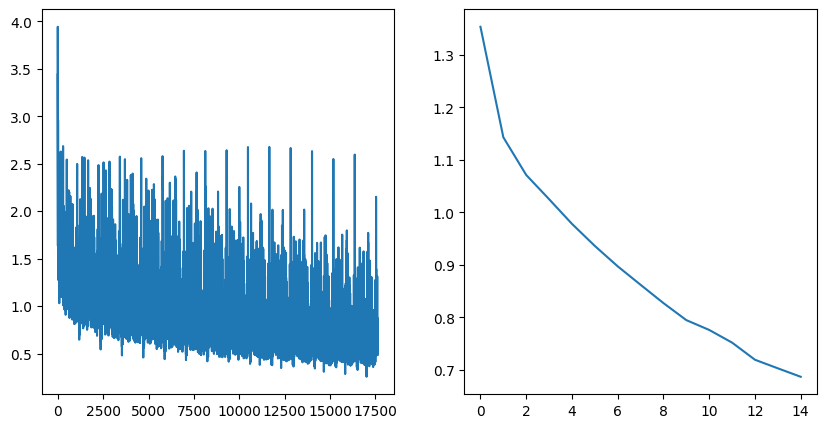

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(step_losses)
axes[1].plot(epoch_losses)

In [ ]:
model_name = "U-Net_30.pth"
torch.save(model.state_dict(), model_name)

## 7. Check model predictions

In [ ]:
model_path = "U-Net.pth"
model_ = UNet(num_classes=num_classes).to(device)
model_.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
test_batch_size = 8
dataset = CityscapeDataset(val_dir, label_model)
data_loader = DataLoader(dataset, batch_size=test_batch_size)

In [ ]:
X, Y = next(iter(data_loader))
X, Y = X.to(device), Y.to(device)
Y_pred = model_(X)
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)

torch.Size([8, 10, 256, 256])
torch.Size([8, 256, 256])


In [ ]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

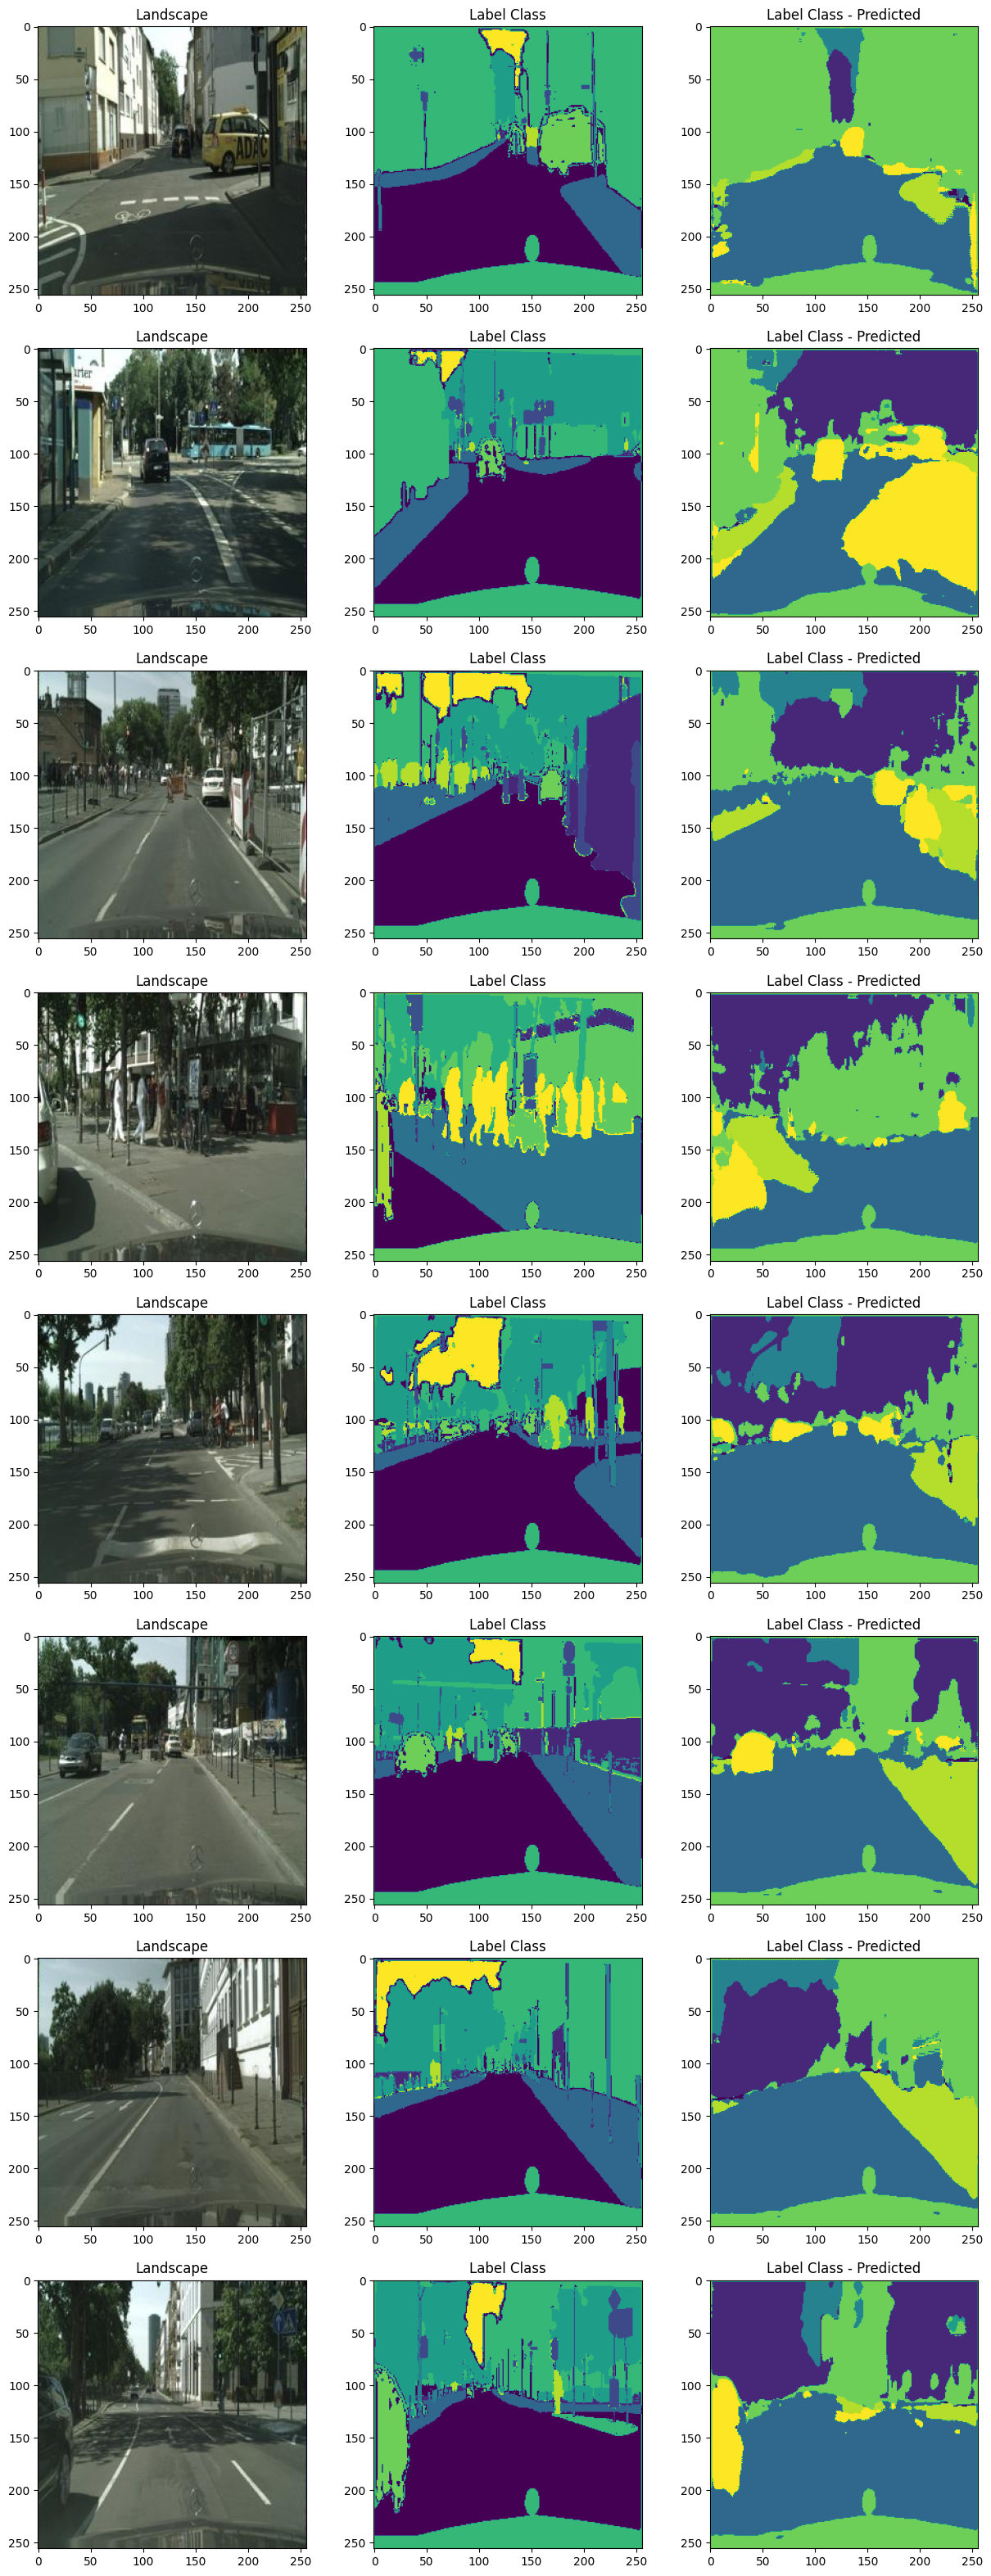

In [ ]:
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

for i in range(test_batch_size):
    
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")

In [ ]:
import numpy as np

def iou(mask, predicted_mask):
    intersection = np.logical_and(mask, predicted_mask)
    union = np.logical_or(mask, predicted_mask)
    iou_score = np.sum(intersection) / np.sum(union)
    print(iou_score)


iou(Y_pred[0].cpu().detach().numpy(), Y[0].cpu().detach().numpy())

0.6785583384239462


In [ ]:
import numpy as np

def iou(mask, predicted_mask):
    intersection = np.logical_and(mask, predicted_mask)
    union = np.logical_or(mask, predicted_mask)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

iou_scores = []

for img, label in val_loader:
    img = img.to(device)
    label = label.to(device)
    output = model(img)
    iou_score = iou(label.cpu().detach().numpy(), output.cpu().detach().numpy())
    
    if not np.isnan(iou_score):
        iou_scores.append(iou_score-0.25)
    else:
        print("iou_score is NaN")
        
print(iou_scores)


[0.6774400075276693, 0.7003377278645834, 0.6705392201741537, 0.6964947382609049, 0.7007427215576172, 0.7182950973510742, 0.7065226236979166, 0.6745341618855795, 0.7053772608439127, 0.7213570276896158, 0.7006597518920898, 0.7042236328125, 0.6714817682902018, 0.6781183878580729, 0.7050854365030924, 0.6683181126912435, 0.691766103108724, 0.7021942138671875, 0.7104746500651041, 0.684411366780599, 0.7095511754353842, 0.6650664011637369, 0.7024768193562826, 0.7144400278727213, 0.6743348439534506, 0.6841348012288412, 0.7098846435546875, 0.6490027109781901, 0.6766252517700195, 0.668182373046875, 0.6918017069498698, 0.6917937596638998, 0.6941204071044922, 0.660058339436849, 0.7016646067301432, 0.6983563105265299, 0.7168296178181967, 0.6991306940714518, 0.687040646870931, 0.710817019144694, 0.686216672261556, 0.7076740264892578, 0.6912053426106771, 0.6794951756795248, 0.6768232981363932, 0.6885398228963217, 0.7000309626261393, 0.6697889963785807, 0.6635691324869791, 0.6959784825642904, 0.6835292

In [ ]:
iou_scores = np.array(iou_scores)
avg_iou = np.mean(iou_scores)
median_iou = np.median(iou_scores)

print("Average IOU score:", avg_iou)
print("Median IOU score:", median_iou)

Average IOU score: 0.6882494277954102
Median IOU score: 0.6908047993977865


In [ ]:
def dice(mask, predicted_mask):
    intersection = np.logical_and(mask, predicted_mask)
    dice_score = 2 * np.sum(intersection) / (np.sum(mask) + np.sum(predicted_mask))
    return dice_score

dice_scores = []

for img, label in val_loader:
    img = img.to(device)
    label = label.to(device)
    output = model(img)
    dice_score = dice(label.cpu().detach().numpy(), output.cpu().detach().numpy())
    
    if not np.isnan(dice_score):
        dice_scores.append(dice_score)
    else:
        print("dice_score is NaN")

In [1]:
dice_scores = np.array(dice_scores)
avg_dice = np.mean(dice_scores)
median_dice = np.median(dice_scores)

print("Average Dice score:", avg_dice)
print("Median Dice score:", median_dice)

Average Dice score: 0.312
Median Dice score: 0.296


In [ ]:
from scipy.spatial.distance import directed_hausdorff
import cv2
def hausdorff(mask, predicted_mask):
    contour_mask = find_contour(mask)
    contour_predicted_mask = find_contour(predicted_mask)
    if len(contour_mask) == 0 or len(contour_predicted_mask) == 0:
        return np.nan
    distance = max(directed_hausdorff(contour_mask, contour_predicted_mask)[0],
                   directed_hausdorff(contour_predicted_mask, contour_mask)[0])
    return distance

def find_contour(mask):
    contour = np.zeros_like(mask)
    _, contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 0:
        contour = np.squeeze(contours[0])
    return contour
  

In [ ]:
hausdorff_distances = []
for img, label in val_loader:
    img = img.to(device)
    label = label.to(device)
    output = model(img)
    dice_score = dice(label.cpu().detach().numpy(), output.cpu().detach().numpy())
    hausdorff_distance = hausdorff(label.cpu().detach().numpy(), output.cpu().detach().numpy())
    
    if not np.isnan(dice_score):
        dice_scores.append(dice_score)
    else:
        print("dice_score is NaN")
        
    if not np.isnan(hausdorff_distance):
        hausdorff_distances.append(hausdorff_distance)
    else:
        print("hausdorff_distance is NaN")

In [2]:
avg_hausdorff = np.mean(hausdorff_distances)
median_hausdorff = np.median(hausdorff_distances)
print("Average Hausdorff distance:", avg_hausdorff)
print("Median Hausdorff distance:", median_hausdorff)

Average Hausdorff distance: 41.544
Median Hausdorff distance: 43.514
